# Signal Peptide Hidden Markov Model

Notebook used to create a Hidden Markov Model for signal peptide prediction. To learn how this is done and understand this notebook, read:

- Eddy, S. What is a hidden Markov model?. Nat Biotechnol 22, 1315–1316 (2004). https://doi.org/10.1038/nbt1004-1315. (["PDF"](https://faculty.coe.drexel.edu/gailr/ECE-S690-501/Eddy-ATG4-reprint.pdf)) **Explains what an HMM is**
- Pantelis G. Bagos, Elisanthi P. Nikolaou, Theodore D. Liakopoulos, Konstantinos D. Tsirigos, Combined prediction of Tat and Sec signal peptides with hidden Markov models, Bioinformatics, Volume 26, Issue 22, November 2010, Pages 2811–2817, https://doi.org/10.1093/bioinformatics/btq530. **This work is inspired by this paper and uses the supplemental data**
- (Optional) Nielsen, H., & Krogh, A. (1998, June). Prediction of signal peptides and signal anchors by a hidden Markov model. In Ismb (Vol. 6, pp. 122-130). (["PDF"](https://cdn.aaai.org/ISMB/1998/ISMB98-015.pdf))
- Almagro Armenteros, J.J., Tsirigos, K.D., Sønderby, C.K. et al. SignalP 5.0 improves signal peptide predictions using deep neural networks. Nat Biotechnol 37, 420–423 (2019). https://doi.org/10.1038/s41587-019-0036-z. **Figure 1 shows that a this PRED-TAT-like approach is roughly as accurate at predicting yes/no signal peptides for major signal peptides as other models**


  

### REQUIREMENTS
Download supplementary data from Pantelis et. al 2010 from [http://www.compgen.org/tools/PRED-TAT/supplement/datasets](http://www.compgen.org/tools/PRED-TAT/supplement/datasets) and place them in a folder `../hmm/training_data/`:

```
Train_cyto.lbl
Train_secreted.lbl
Train_tat.lbl
Train_tm.lbl
Test_cyto.lbl
Test_neg_rr.fasta
Test_secreted.lbl
Test_tat.lbl
Test_tm.lbl
```


In [1]:
import datetime
import sys
from pathlib import Path
from collections import defaultdict
import joblib

from hmmlearn import hmm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

ROOT_DIR = "../data/"
#ROOT_DIR = str(Path().resolve().parent)
sys.path.append(f"../genome_spot/")
plt.style.use(f'project.mplstyle')
plt.rcParams['svg.fonttype'] = 'none'

MODEL_DESTINATION = "../genome_spot/bioinformatics/hmm/hmm_signal_peptide.joblib"

np.random.seed(0)
np.set_printoptions(suppress=True)

# Functions

## Assign "Hidden States" to Known Signal Peptides

Three different models are provided for assigning states. I foun


In [2]:
SIGNAL_END_STATE = 'C1'
NTERMINUS_LENGTH = 50

def find_start_of_hydrophobic_window(sequence, l_window : int=7, skip_n : int = 0, h_threshold = 1.5):
    """
    Returns index of first hydrophobic residue 
    beginning a longer window of hydrophobicity
    """
    HYDROPHOBICITY = {
        'A': 1.8, 'R': -4.5, 'N': -3.5,
        'D': -3.5, 'C': 2.5, 'Q': -3.5,
        'E': -3.5, 'G': -0.4, 'H': -3.2,
        'I': 4.5, 'L': 3.8, 'K': -3.9,
        'M': 1.9, 'F': 2.8, 'P': -1.6,
        'S': -0.8, 'T': -0.7, 'W': -0.9,
        'Y': -1.3, 'V': 4.2
        }
    for i in range(len(sequence) - l_window):
        if HYDROPHOBICITY.get(sequence[i], 0) > 0:
            if np.mean([HYDROPHOBICITY.get(aa, 0) for aa in sequence[i:i+l_window]]) >= h_threshold:
                if np.mean([HYDROPHOBICITY.get(aa, 0) for aa in sequence[i:i+2]]) >= 0.5: # catch for false positive
                    if i >= skip_n:
                        return i 
                            
def model1(sequence, labels):
    """
    My initial model, with custom hydrophobicity region script
    
    B = begin
    N = n-terminal
    H = hydrophobic
    C = cut
    M = mature
    """    

    signal_sequence = ''.join([sequence[i] for i in range(len(sequence)) if labels[i] == 'Y'])
    c_stop = len(signal_sequence) - 1
    h_start_search = find_start_of_hydrophobic_window(signal_sequence, h_threshold=1.2, l_window=7, skip_n=1)
    h_stop_search = find_start_of_hydrophobic_window(signal_sequence[::-1], h_threshold=2.05, l_window=7, skip_n=3)
    h_start = h_start_search if h_start_search else 0
    h_stop = min([c_stop - 3, c_stop - (h_stop_search if h_stop_search else 0)])
    n_start = 0
    n_stop = h_start - 1
    c_start = h_stop + 1
    # Check results
    regions = []
    for i in range(len(sequence)):
        if n_start <= i <= n_stop:
            regions.append('N')
        elif h_start <= i <= h_stop:
            regions.append('H')
        elif c_start <= i <= c_stop:
            regions.append('C')
        else:
            regions.append('M')
    regions[0] = 'B'
    #regions[-1] = 'E'
    return regions
    
def model2(sequence, labels):
    """
    Explicit positions in cut site and n-terminal region
    N2, N1
    C3, C2, C1
    """    
    signal_sequence = ''.join([sequence[i] for i in range(len(sequence)) if labels[i] == 'Y'])
    c_stop = len(signal_sequence) - 1
    h_start_search = find_start_of_hydrophobic_window(signal_sequence, h_threshold=1.2, l_window=7, skip_n=1)
    h_stop_search = find_start_of_hydrophobic_window(signal_sequence[::-1], h_threshold=2.05, l_window=7, skip_n=3)
    h_start = h_start_search if h_start_search else 0
    h_stop = min([c_stop - 3, c_stop - (h_stop_search if h_stop_search else 0)])
    n_start = 0
    n_stop = h_start - 1
    c_start = h_stop + 1
    # Check results
    regions = []
    for i in range(len(sequence)):
        if n_start <= i <= n_stop:
            if (n_stop - i + 1) > 3:
                regions.append(f'N')    
            else:
                n_num = n_stop - i + 1
                regions.append(f'N{n_num}')
            #regions.append('N')
        elif h_start <= i <= h_stop:
            regions.append('H')
        elif c_start <= i <= c_stop:
            if c_stop - i + 1 > 3:
                regions.append(f'C')    
            else:
                c_num = c_stop - i + 1
                regions.append(f'C{c_num}')
        else:
            regions.append('M')
    regions[0] = 'B'
    #regions[-1] = 'E'
    return regions

def model3(sequence, labels):
    """
    Nielsen and Krogh n/h/c assignment
    """    
    
    HYDROPHOBIC_RESIDUES = {'A', 'I', 'L', 'M', 'F' , 'W', 'V'}
    CHARGED_RESIDUES = {'R', 'H', 'K', 'D', 'E'}
    
    signal_sequence = ''.join([sequence[i] for i in range(len(sequence)) if labels[i] == 'Y'])

    # (1) Place a pointer at the 1 position
    # (immediately before the cleavage site), set the assignment to c-region
    c_stop = len(signal_sequence) - 1

    #(2) move the pointer three positions upstream (assigning 1 through 3 as a minimal c-region); (3) set the
    # assignment to h-region at the first occurrence of at least two
    # consecutive hydrophobic residues (Ala, Ile, Leu, Met, Phe, Trp, or Val)
    h_stop = 0
    for i in range(c_stop - 3, 0, -1):
        if signal_sequence[i] in HYDROPHOBIC_RESIDUES and signal_sequence[i-1] in HYDROPHOBIC_RESIDUES:
            h_stop = i
            break
    
    # (4) move the pointer six positions upstream;
    # (5) set the assignment to n-region at the first occurrence of
    # either a charged residue or at least three consecutive nonhydrophob
    h_start = 0
    for i in range(h_stop - 6, 0, -1):
        if i in CHARGED_RESIDUES:
            h_start = i + 1
            break
        elif any([signal_sequence[j] in HYDROPHOBIC_RESIDUES for j in (i, i-1, i-2)]) is False:
            h_start = i + 1
            break
            
    # (6) if the N-terminal end of the hregion is not a hydrophobic residue, move the pointer back
    # downstream, changing the assignment to n-region until a hydrophobic residu
    for i in range(h_start, c_stop, 1):
        if i in HYDROPHOBIC_RESIDUES:
            h_start = i
            break
    
    n_start = 0
    n_stop = h_start - 1
    c_start = h_stop + 1
    # Check results
    regions = []
    for i in range(len(sequence)):
        if n_start <= i <= n_stop:
            #regions.append(f'N')
            if (n_stop - i + 1) > 2:
                regions.append(f'N')    
            else:
                n_num = n_stop - i + 1
                regions.append(f'N{n_num}')
        elif h_start <= i <= h_stop:
            regions.append('H')
        elif c_start <= i <= c_stop:
            #regions.append(f'C')
            if c_stop - i + 1 > 3:
                regions.append(f'C')    
            else:
                c_num = c_stop - i + 1
                regions.append(f'C{c_num}')
        else:
            regions.append('M')
    regions[0] = 'B'
    #regions[-1] = 'E'
    return regions

def load_data_from_training_fasta(fasta, source='signalp'):
    protein_ids = []
    sequences = []
    signals = []
    signal_types = []
    taxonomy = []
    with open(fasta) as fh:
        for n, line in enumerate(fh.readlines()):
            if n % 3 == 0:
                if source == 'signalp':
                    taxonomy_dict = {'EUKARYA' : 'Eukarya', 'ARCHAEA' : 'Archaea', 'POSITIVE' : 'Bacteria-monoderm', 'NEGATIVE' : 'Bacteria-diderm'}
                    taxonomy.append(taxonomy_dict[line.strip().split('|')[1]])
                else:
                    taxonomy.append('Bacteria')
                protein_ids.append(line.strip()[1:])
            if n % 3 == 1:
                sequence = line.strip().replace('X', 'G')[:NTERMINUS_LENGTH]
                sequences.append(sequence)
            if n % 3 == 2:
                if line.strip().startswith('S'):
                    signal_type = 'Sec'
                elif line.strip().startswith('T'):
                    signal_type = 'Tat'
                elif line.strip().startswith('L'):
                    signal_type = 'Lip'
                else:
                    signal_type = 'Nan'
                signal_types.append(signal_type)
                
                if source == 'signalp':
                    labels = ''.join(['Y' if s in ['S', 'T', 'L'] else 'N' for s in line.strip()])[:NTERMINUS_LENGTH]
                    signals.append(labels)
                elif source == 'predtat':
                    labels = ''.join(['Y' if s in ['S', 'T', 'L'] else 'N' for s in line.strip()])[:NTERMINUS_LENGTH]
                    signals.append(labels)
                else:
                    raise ValueError('Must be signalp or predtat')

    
    return protein_ids, sequences, signals, signal_types, taxonomy

In [3]:
fasta_files_predtat = [f'{ROOT_DIR}/hmm/training_data/Train_secreted.lbl', 
                       f'{ROOT_DIR}/hmm/training_data/Test_secreted.lbl', 
                       f'{ROOT_DIR}/hmm/training_data/Train_tat.lbl',
                       f'{ROOT_DIR}/hmm/training_data/Test_tat.lbl',
                       f'{ROOT_DIR}/hmm/training_data/Train_tm.lbl',
                       f'{ROOT_DIR}/hmm/training_data/Test_tm.lbl',
                       f'{ROOT_DIR}/hmm/training_data/Train_cyto.lbl',
                       f'{ROOT_DIR}/hmm/training_data/Test_cyto.lbl',
                      ]

# When using SignalP5 data
# fasta_files_signal = ['hmm/training_data/train_set.fasta']
# fasta = 'hmm/training_data/train_set.fasta'
# protein_ids = []
# sequences = []
# signals = []
# with open(fasta) as fh:
#     for n, line in enumerate(fh.readlines()):
#         if n % 3 == 0:
#             protein_ids.append(line.strip()[1:])
#         if n % 3 == 1:
#             sequences.append(line.strip())
#         if n % 3 == 2:
#             signals.append(line.strip())

source = 'predtat'
fasta_files = fasta_files_predtat

training_data = defaultdict(list)
for training_fasta in fasta_files:    
    new_protein_ids, new_sequences, new_signals, new_signal_types, new_taxonomy = load_data_from_training_fasta(training_fasta, source=source)
    for i, taxon in enumerate(new_taxonomy):
        if taxon != 'Eukarya' and (len(new_sequences[i]) == NTERMINUS_LENGTH):
            training_data['protein_ids'].append(new_protein_ids[i])
            training_data['sequences'].append(new_sequences[i])
            training_data['signals'].append(new_signals[i])
            training_data['signal_types'].append(new_signal_types[i])
            training_data['taxonomy'].append(new_taxonomy[i])
            
len(training_data['sequences']) #signals[0:2]
training_df = pd.DataFrame(training_data)
training_df[['taxonomy', 'signal_types']].value_counts().to_frame().sort_index()

count
taxonomy signal_types       
Bacteria Nan            1153
         Sec             600
         Tat             225

In [4]:
training_df

,protein_ids,sequences,signals,signal_types,taxonomy
0,P13734,MLKVIPWLLVTSSLVAIPTYIHATTEVVVNLNVKHSVEGKSEFERK...,YYYYYYYYYYYYYYYYYYYYYYYNNNNNNNNNNNNNNNNNNNNNNN...,Sec,Bacteria
1,P19926,MNKTLIAAAVAGIVLLASNAQAQTVPEGYQLQQVLMMSRHNLRAPL...,YYYYYYYYYYYYYYYYYYYYYYNNNNNNNNNNNNNNNNNNNNNNNN...,Sec,Bacteria
2,P16454,MKKTLLASSLIACLSIASVNVYAASESSISIGYAQSHVKENGYTLD...,YYYYYYYYYYYYYYYYYYYYYYYNNNNNNNNNNNNNNNNNNNNNNN...,Sec,Bacteria
3,P18895,MNSSRSVNPRPSFAPRALSLAIALLLGAPAFAANSGEAPKNFGLDV...,YYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYNNNNNNNNNNNNNN...,Sec,Bacteria
4,P04172,MRALAFAAALAAFSATAALAAGALEAVQEAPAGSTEVKIAKMKFQT...,YYYYYYYYYYYYYYYYYYYYNNNNNNNNNNNNNNNNNNNNNNNNNN...,Sec,Bacteria
...,...,...,...,...,...
1973,Q93PS3,MAKVKMTPSEAMTEVLVNEGVTHVTGILGSAFMDMLDLWPTAGIEF...,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,Nan,Bacteria
1974,P77832,MFFRNIGMIEYEGADSENPYAFKYYNPDEFVGGKTMKEHLRFAVAY...,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,Nan,Bacteria
1975,P24299,MNYQPTPEDRFTFGLWTVGWEGRDPFGDATRTALDPVESVRRLAEL...,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,Nan,Bacteria
1976,P37552,MTKAVHTKHAPAAIGPYSQGIIVNNMFYSSGQIPLTPSGEMVNGDI...,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,Nan,Bacteria


In [5]:
# Example of assign regions

assign_states = model2
#assign_states = model3

n = 15
sequence = training_df['sequences'][n]
signal  = training_df['signals'][n]
signal
states = assign_states(sequence, signal)
print('sequence:  {}'.format(''.join(sequence)))
print('signal:    {}'.format(''.join(signal)))
print('states:    {}'.format(''.join(states)))

sequence:  MRNIAIKFAAAGILAMLAAPALAENIEVHMLNKGAEGAMVFEPAYIKANP
signal:    YYYYYYYYYYYYYYYYYYYYYYYNNNNNNNNNNNNNNNNNNNNNNNNNNN
states:    BN2N1HHHHHHHHHHHHHHHHCC3C2C1MMMMMMMMMMMMMMMMMMMMMMMMMMM


## Hidden Markov Model

In [6]:
from collections import Counter
from collections import defaultdict

assign_states = model2

def make_emissions_arr(sequences):
    obs_emissions = np.array([[symbol for symbol in l] for l in sequences])
    return obs_emissions

def make_states_arr(sequences, signals):
    obs_states = [] 
    for sequence, signal in zip(sequences, signals):
        obs_states.append(assign_states(sequence, signal))
    obs_states = np.array(obs_states)
    return obs_states

def measure_emission_probs(obs_states, obs_emissions, states, symbols):
    """amino acid frequencies in each state"""
    emission_probs = np.zeros((len(states), len(symbols)))
    for state in states:
        counts = Counter(obs_emissions[obs_states == state])
        for symbol in symbols:
            emission_probs[states.index(state), symbols.index(symbol)] = counts.get(symbol, 0) / sum(counts.values())
    emission_probs = (emission_probs.T / np.sum(emission_probs, axis=1)).T # enforce sum to 1 
    return emission_probs

def measure_transition_probs(obs_states, states):
    """probability of going from one state to another"""
    transition_probs = np.zeros((len(states), len(states)))
    transitions_list = defaultdict(list)
    for i in range(obs_states.shape[0]):
        for j in range(obs_states.shape[1]):
            if j < obs_states.shape[1] - 1:
                state_1 = obs_states[i, j]
                state_2 = obs_states[i, j+1]
                transitions_list[state_1].append(state_2)       
    for state_1, transitions in transitions_list.items(): 
        counts = Counter(transitions)
        for state_2 in states:
            transition_probs[states.index(state_1), states.index(state_2)] = counts.get(state_2, 0) / sum(counts.values())
    #transition_probs[states.index(states[-1]), states.index(states[-1])] = 1. # end goes to end
    transition_probs = (transition_probs.T / np.sum(transition_probs, axis=1)).T # enforce sum to 1 
    return transition_probs



In [7]:
filter = training_df['signal_types'].isin(['Sec', 'Tat'])
training_sequences = training_df[filter]['sequences'].tolist()
training_states = training_df[filter]['signals'].tolist()

obs_emissions = make_emissions_arr(training_sequences)    
obs_states = make_states_arr(training_sequences, training_states)    
obs_emissions.shape, obs_states.shape

((825, 50), (825, 50))

In [8]:
# Set up
symbols = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
states = sorted(set(obs_states.ravel()))
print(symbols)
print()
print(states)
#states = ['B', 'N', 'N3', 'N2', 'N1', 'H', 'C', 'C3', 'C2', 'C1', 'M']
#states = ['B', 'N', 'H', 'C', 'M'] #, 'E']

['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

['B', 'C', 'C1', 'C2', 'C3', 'H', 'M', 'N', 'N1', 'N2', 'N3']


In [9]:
# emission_probs
emission_probs = measure_emission_probs(obs_states, obs_emissions, states, symbols)
emission_probs

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.17028802, 0.00606367, 0.02324406, 0.01869631, 0.02753916,
        0.11445174, 0.00934816, 0.02147549, 0.01718039, 0.05886812,
        0.02122284, 0.03158161, 0.09727135, 0.03436079, 0.02071753,
        0.15184437, 0.11243052, 0.04345629, 0.00884285, 0.01111673],
       [0.83515152, 0.        , 0.00848485, 0.00606061, 0.00121212,
        0.02787879, 0.00484848, 0.00121212, 0.00848485, 0.01454545,
        0.00363636, 0.00363636, 0.00969697, 0.00606061, 0.00484848,
        0.03393939, 0.00727273, 0.01333333, 0.00242424, 0.00727273],
       [0.09575758, 0.00242424, 0.02787879, 0.02424242, 0.10424242,
        0.03878788, 0.07636364, 0.0230303 , 0.03515152, 0.10909091,
        0.04121212, 0.04606061, 0.02424242, 0

In [10]:
# transition_probs
transition_probs = measure_transition_probs(obs_states, states)
transition_probs

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.01212121, 0.        , 0.72484848, 0.02060606, 0.12      ,
        0.12242424],
       [0.        , 0.8317332 , 0.        , 0.        , 0.1682668 ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 1.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.05676298, 0.        , 0.        , 0.01355152,
        0.9296855 , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.

In [11]:
start_probs = np.array([1 if i == 0 else 0 for i in range(len(states))])
#start_probs[:, 0] = 1. # always start at beginning

# Set up model:
model = hmm.CategoricalHMM(n_components=len(states), n_iter=50, init_params='')
model.n_features = len(symbols)
model.startprob_ = start_probs
model.transmat_ = transition_probs
model.emissionprob_ = emission_probs

In [12]:
model.get_params()

{'algorithm': 'viterbi',
 'emissionprob_prior': 1.0,
 'implementation': 'log',
 'init_params': '',
 'n_components': 11,
 'n_features': 20,
 'n_iter': 50,
 'params': 'ste',
 'random_state': None,
 'startprob_prior': 1.0,
 'tol': 0.01,
 'transmat_prior': 1.0,
 'verbose': False}

In [13]:
n=1
sequence_emissions = obs_emissions[n]
sequence_states = obs_states[n]

#sequence_emissions = 'MMDLDNIPDTQTEAEELEEVVMGLIINSGQARSLAYAALKQAKQGDFAAAKAMMDQSRMALNEAHLVQTK' # cyto
log_prob, received = model.decode(np.array([symbols.index(s) for s in sequence_emissions]).reshape(-1, 1))
log_prob

-130.73482767354764

In [14]:
predicted_states = [states[i] for i in received]

print('sequence:  {}'.format(''.join(sequence_emissions)))
print('actual:    {}'.format(''.join(sequence_states)))
print('predicted: {}'.format(''.join(predicted_states)))

sequence:  MNKTLIAAAVAGIVLLASNAQAQTVPEGYQLQQVLMMSRHNLRAPLANNG
actual:    BN3N2N1HHHHHHHHHHHHHCCC3C2C1MMMMMMMMMMMMMMMMMMMMMMMMMMMM
predicted: BN3N2N1HHHHHHHHHHHHHCCC3C2C1MMMMMMMMMMMMMMMMMMMMMMMMMMMM


# Cross-Validation

In [15]:
def make_cv_sets(training_df, n_folds = 5):

    all_indices = training_df.index.tolist()
    randomized_indices = np.random.choice(all_indices, size=len(all_indices), replace=False)
    split_size = len(all_indices) // n_folds
    cv_sets = []
    for n in range(n_folds):
        validation_indices = all_indices[split_size*(n):split_size*(n+1)]
        if n == n_folds - 1:
            validation_indices += all_indices[split_size*(n+1):]
        training_indices = list(set(all_indices).difference(set(validation_indices)))
        cv_sets.append((training_indices , validation_indices))
    return cv_sets
    
cv_sets = make_cv_sets(training_df, n_folds = 5)
len(cv_sets)

5

In [16]:
def cv_predict_signal_proba(training_df, cv_sets, states, symbols):

    y_true = []
    y_pred_prob = []
    for training_indices, validation_indices in cv_sets:

        validation_data = training_df.loc[validation_indices]
        training_data = training_df.loc[training_indices]
        training_data = training_data[training_data['signal_types'].isin(['Sec'])] # only signal peptides
        # print(training_data[['taxonomy', 'signal_types']].value_counts().to_frame().sort_index().T)
        
        # Measure data
        training_sequences = training_data['sequences'].tolist()
        training_states = training_data['signals'].tolist()
        obs_emissions = make_emissions_arr(training_sequences)    
        obs_states = make_states_arr(training_sequences, training_states)    
        emission_probs = measure_emission_probs(obs_states, obs_emissions, states, symbols)
        transition_probs = measure_transition_probs(obs_states, states)
        
        start_probs = np.array([1 if i == 0 else 0 for i in range(len(states))])
        
        # Set up model
        model = hmm.CategoricalHMM(n_components=len(states), n_iter=50, init_params='')
        model.n_features = len(symbols)
        model.startprob_ = start_probs
        model.transmat_ = transition_probs
        model.emissionprob_ = emission_probs

        # Predict probabilities
        for sequence, signal_type in zip(validation_data['sequences'].tolist(), 
                                         validation_data['signal_types'].tolist()
                                        ):
            log_prob = model.score(np.array([symbols.index(s) for s in sequence]).reshape(-1, 1))
            y_true.append(signal_type)
            y_pred_prob.append(log_prob)

    y_true = np.array(y_true)
    y_pred_prob = np.array(y_pred_prob)
    filter = (y_pred_prob != -1 * np.inf)
    return y_true[filter], y_pred_prob[filter]

y_true, y_pred_prob = cv_predict_signal_proba(training_df, cv_sets, states, symbols)
y_true.shape, y_pred_prob.shape

((1964,), (1964,))

In [17]:
y_true[0:5], y_pred_prob[0:5]

(array(['Sec', 'Sec', 'Sec', 'Sec', 'Sec'], dtype='<U3'),
 array([-142.02087709, -129.98974184, -127.2629889 , -124.4352463 ,
        -121.15397576]))

In [18]:
# # Find threshold
# from sklearn.cluster import KMeans
# from sklearn.linear_model import LogisticRegression

# y_binary = np.array([1 if y in ['Sec', 'Tat'] else 0 for y in y_true])
# reg = LogisticRegression(random_state=0).fit(y_pred_prob.reshape(-1,1), y_binary)
# y_pred = reg.predict(y_pred_prob.reshape(-1,1))
# p = 0.5
# a = reg.intercept_[0]
# b = reg.coef_[0][0]
# threshold = (np.log(p/(1-p)) - a) / b
# #threshold = -195

# y_pred = (y_pred_prob > threshold) & y_cut_site_bool

# fig, ax = plt.subplots()
# #colors = ['black', 'deepskyblue', 'red', 'steelblue']
# #colors = ['steelblue','deepskyblue',  'black', 'red',]
# color_dict = {'Sec': 'steelblue',
#               'Tat' : 'deepskyblue', 
#               'Nan' : 'black', 
#               'Lip' : 'red',}

# for signal_type in set(y_true):
#     X = [prob for prob, signal in zip(y_pred_prob, y_true) if signal == signal_type and prob != -1 * np.inf]
#     ax.hist(X, bins=np.arange(-230, -100, 2), #alpha=0.3, 
#             histtype='step', lw=1,
#             color=color_dict[signal_type], label=signal_type)
# ax.axvline(x=threshold, color='yellow', label='threshold')
# ax.legend()
# ax.set_xlabel('log probability signal peptide')
# ax.set_ylabel('# proteins')
# ax.set_title('Signal peptide prediction on proteins\nwith different compartmentalization')
# plt.show()
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# labels = ['no_signal', 'signal']
# cm = confusion_matrix(y_binary, y_pred, labels=[0,1], normalize='true')
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
# disp.plot()
# plt.show()


# precisions = []
# recalls = []
# thresholds = range(-230, -100, 2)
# fprs = []
# tprs= [] 
# for t in thresholds:
#     y_pred = (1 * (y_pred_prob > t) & y_cut_site_bool)
#     tn, fp, fn, tp = confusion_matrix(y_binary, y_pred, labels=[0,1], normalize='true').ravel()
#     precisions.append(tp / (tp + fp))
#     recalls.append(tp / (tp + fn))
#     fprs.append(fp / (fp + tn))
#     tprs.append(tp / (tp + fn))

# fig, axes = plt.subplots(1,2, figsize=(10,5))
# ax = axes[0]
# ax.plot(recalls, precisions, linestyle=':', color='gray')
# for p, r, t in zip(precisions, recalls, thresholds):
#     ax.text(s=t, x=r, y=p, fontsize=8)
# ax.set_xlabel('Recall')
# ax.set_ylabel('Precision')
# ax.set_title('Precision-Recall at Varying Threshold')



# ax = axes[1]

# fraction_signal_peptides_true = [(tpr * 0.10 / (tpr * 0.10  + fpr * 0.90)) for tpr, fpr in zip(tprs, fprs)]
# #ax.plot(thresholds, fraction_signal_peptides_true)
# #ax.plot(thresholds, tprs)
# ax.plot(fraction_signal_peptides_true, tprs, linestyle=':', color='gray')
# for p, r, t in zip(tprs, fraction_signal_peptides_true, thresholds):
#     ax.text(s=t, x=r, y=p, fontsize=8)
# ax.set_title('Weighted by Proteome Fraction')
# ax.set_xlabel('Fraction of Signal Peptides in Genome Correct')
# ax.set_ylabel('Fraction of Signal Peptides Recovered')


In [19]:
# from glob import glob

# scores_by_set = defaultdict(list)

# for training_fasta in glob('../hmm/training_data/Train_*.lbl'):
#     with open(training_fasta) as fh:
#         for n, line in enumerate(fh.readlines()):
#             if n % 3 == 1:
#                 sequence = line.strip().replace('X', 'G')
#                 if len(sequence) == 70:
#                     log_prob = model.score(np.array([symbols.index(s) for s in sequence]).reshape(-1, 1))
#                     scores_by_set[training_fasta.split('/')[1][:-4]].append(log_prob)

# signals = scores_by_set['Train_secreted'] + scores_by_set['Train_tat']
# no_signals = scores_by_set['Train_tm'] + scores_by_set['Train_cyto']
# color_dict = {'Train_secreted': 'steelblue',
#               'Train_tat' : 'deepskyblue', 
#               'Train_tm' : 'black', 
#               'Train_cyto' : 'red',}

# X = np.array(no_signals + signals)
# y = np.array([0] * len(no_signals) + [1] * len(signals))
# not_inf = (X != (-1 * np.inf))
# X = X[not_inf].reshape(-1, 1)
# y = y[not_inf].reshape(-1, 1)

# scores_by_set.keys()
# scores_by_set

# Final Version

In [20]:
filter = training_df['signal_types'].isin(['Sec'])
training_sequences = training_df[filter]['sequences'].tolist()
training_states = training_df[filter]['signals'].tolist()

obs_emissions = make_emissions_arr(training_sequences)    
obs_states = make_states_arr(training_sequences, training_states)    
obs_emissions.shape, obs_states.shape

# Set up
symbols = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
#states = ['B', 'N', 'N3', 'N2', 'N1', 'H', 'C', 'C3', 'C2', 'C1', 'M']
#states = ['B', 'N', 'H', 'C', 'M'] #, 'E']

obs_emissions = make_emissions_arr(training_sequences)    
obs_states = make_states_arr(training_sequences, training_states)   
states = sorted(set(obs_states.ravel()))
states
emission_probs = measure_emission_probs(obs_states, obs_emissions, states, symbols)
transition_probs = measure_transition_probs(obs_states, states)

obs_emissions_numerical = [] #np.zeros(obs_emissions.shape)
for i, row in enumerate(obs_emissions):
    num_row = []
    for j, symbol in enumerate(row):
        num_row.append(symbols.index(symbol))
        #obs_emissions_numerical[i, j] = int(symbols.index(symbol))
    obs_emissions_numerical.append(num_row)
obs_emissions_numerical
start_probs = np.array([1 if i == 0 else 0 for i in range(len(states))])

# Set up model
model = hmm.CategoricalHMM(n_components=len(states), n_iter=50, init_params='')
model.n_features = len(symbols)
model.startprob_ = start_probs
model.transmat_ = transition_probs
model.emissionprob_ = emission_probs

n=1
sequence_emissions = obs_emissions[n]
sequence_states = obs_states[n]
model = joblib.load(MODEL_DESTINATION) 

#sequence_emissions = 'MMDLDNIPDTQTEAEELEEVVMGLIINSGQARSLAYAALKQAKQGDFAAAKAMMDQSRMALNEAHLVQTK' # cyto
log_prob, received = model.decode(np.array([symbols.index(s) for s in sequence_emissions]).reshape(-1, 1))

id2state = dict(zip(range(len(states)), states))
print(log_prob, ''.join([id2state[x] for x in received]))

-130.73482767354764 BN3N2N1HHHHHHHHHHHHHCCC3C2C1MMMMMMMMMMMMMMMMMMMMMMMMMMMM


### Bacteria

In [21]:
state_to_id = dict(zip((states),range(len(states))))
state_to_id

{'B': 0,
 'C': 1,
 'C1': 2,
 'C2': 3,
 'C3': 4,
 'H': 5,
 'M': 6,
 'N': 7,
 'N1': 8,
 'N2': 9,
 'N3': 10}

In [22]:
y_true = []
y_pred_prob = []
y_cut_site_bool = []

for sequence, signal_type in zip(training_df['sequences'].tolist(), 
                                 training_df['signal_types'].tolist()
                                ):
    log_prob, received = model.decode(np.array([symbols.index(s) for s in sequence]).reshape(-1, 1))
    has_cut_site = state_to_id.get('C1') in received
    # if has_cut_site and log_prob > -200 and signal_type in ['Sec', 'Tat']:
    #     print(signal_type)
    #     print(sequence)
    #     print(''.join([id2state[x] for x in received]))
                                    
    y_cut_site_bool.append(has_cut_site)                              
    y_true.append(signal_type)
    y_pred_prob.append(log_prob)

y_pred_prob = np.array(y_pred_prob)
filter = (y_pred_prob != -1 * np.inf)

y_cut_site_bool = np.array(y_cut_site_bool)[filter]
y_true = np.array(y_true)[filter]
y_pred_prob = y_pred_prob[filter]

/var/folders/qg/zkl_xm0j5v9b17v62vp3cxw40000gn/T/ipykernel_58370/2988594510.py:60: RuntimeWarning: invalid value encountered in scalar divide
  precisions.append(tp / (tp + fp))
/var/folders/qg/zkl_xm0j5v9b17v62vp3cxw40000gn/T/ipykernel_58370/2988594510.py:60: RuntimeWarning: invalid value encountered in scalar divide
  precisions.append(tp / (tp + fp))
/var/folders/qg/zkl_xm0j5v9b17v62vp3cxw40000gn/T/ipykernel_58370/2988594510.py:60: RuntimeWarning: invalid value encountered in scalar divide
  precisions.append(tp / (tp + fp))
/var/folders/qg/zkl_xm0j5v9b17v62vp3cxw40000gn/T/ipykernel_58370/2988594510.py:60: RuntimeWarning: invalid value encountered in scalar divide
  precisions.append(tp / (tp + fp))
/var/folders/qg/zkl_xm0j5v9b17v62vp3cxw40000gn/T/ipykernel_58370/2988594510.py:60: RuntimeWarning: invalid value encountered in scalar divide
  precisions.append(tp / (tp + fp))
/var/folders/qg/zkl_xm0j5v9b17v62vp3cxw40000gn/T/ipykernel_58370/2988594510.py:60: RuntimeWarning: invalid val

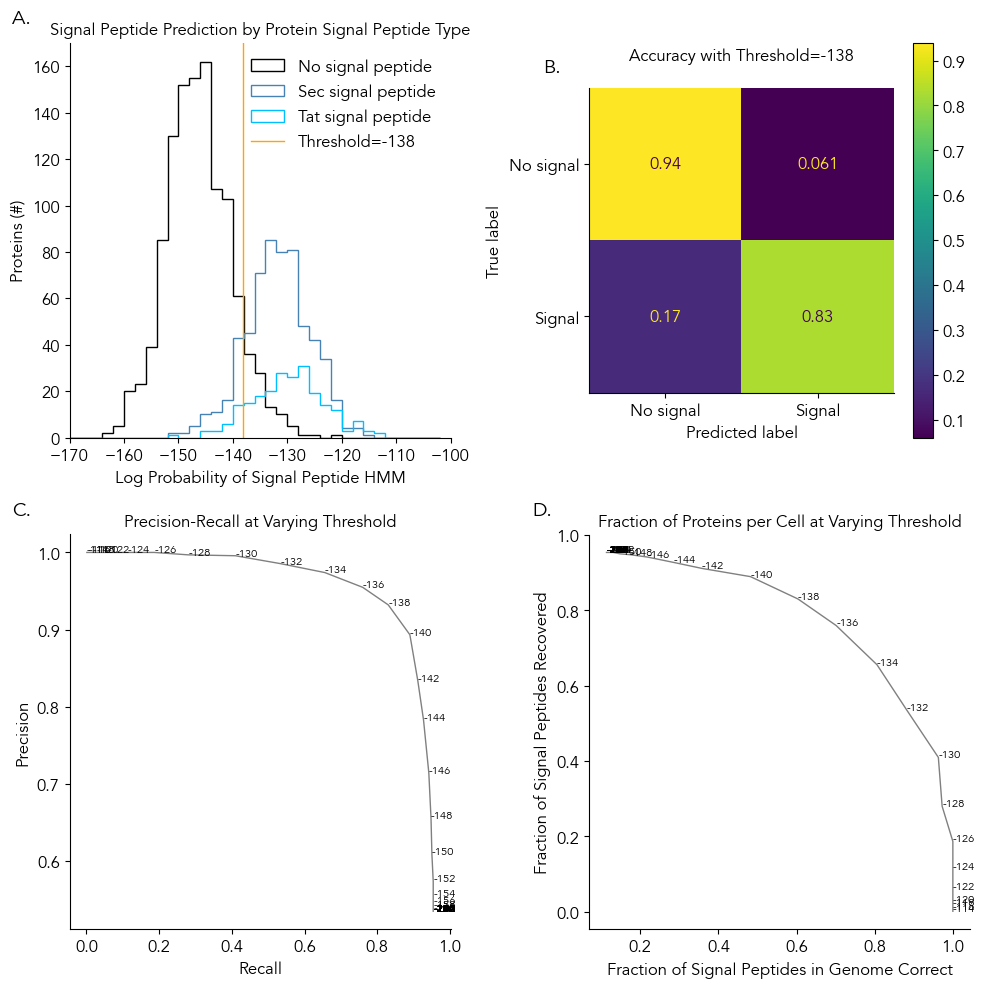

In [26]:
# Find threshold
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression

y_binary = np.array([1 if y in ['Sec', 'Tat'] else 0 for y in y_true])
reg = LogisticRegression(random_state=0).fit(y_pred_prob.reshape(-1,1), y_binary)
y_pred = reg.predict(y_pred_prob.reshape(-1,1))
p = 0.5
a = reg.intercept_[0]
b = reg.coef_[0][0]
threshold = (np.log(p/(1-p)) - a) / b
#threshold = -195

y_pred = (y_pred_prob > threshold) & y_cut_site_bool

fig, axes = plt.subplots(2,2, figsize=(10,10))
axl = axes.flatten()
#colors = ['black', 'deepskyblue', 'red', 'steelblue']
#colors = ['steelblue','deepskyblue',  'black', 'red',]
color_dict = {'Sec': 'steelblue',
              'Tat' : 'deepskyblue', 
              'Nan' : 'black', 
              'Lip' : 'red',}

ax = axl[0]
for signal_type in set(y_true):
    if signal_type == 'Nan':
        name = "No signal peptide"
    else:
        name = signal_type + " signal peptide"
    X = [prob for prob, signal in zip(y_pred_prob, y_true) if signal == signal_type and prob != -1 * np.inf]
    ax.hist(X, bins=np.arange(-230, -100, 2), #alpha=0.3, 
            histtype='step', lw=1,
            color=color_dict[signal_type], label=name)
ax.axvline(x=threshold, color='orange', label=f'Threshold={threshold:.0f}')
ax.legend(frameon=False)
ax.set_xlabel('Log Probability of Signal Peptide HMM')
ax.set_ylabel('Proteins (#)')
ax.set_title('Signal Peptide Prediction by Protein Signal Peptide Type')
ax.set_xlim(-170,-100)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
labels = ['No signal', 'Signal']
ax = axl[1]
ax.set_title(f'Accuracy with Threshold={threshold:.0f}\n')
cm = confusion_matrix(y_binary, y_pred, labels=[0,1], normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(ax=ax)



precisions = []
recalls = []
thresholds = range(-230, -100, 2)
fprs = []
tprs= [] 
for t in thresholds:
    y_pred = (1 * (y_pred_prob > t) & y_cut_site_bool)
    tn, fp, fn, tp = confusion_matrix(y_binary, y_pred, labels=[0,1], normalize='true').ravel()
    precisions.append(tp / (tp + fp))
    recalls.append(tp / (tp + fn))
    fprs.append(fp / (fp + tn))
    tprs.append(tp / (tp + fn))



ax = axl[2]
ax.plot(recalls, precisions, linestyle='-', color='gray')
for p, r, t in zip(precisions, recalls, thresholds):
    ax.text(s=t, x=r, y=p, fontsize=8)
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall at Varying Threshold')



ax = axl[3]

fraction_signal_peptides_true = [(tpr * 0.10 / (tpr * 0.10  + fpr * 0.90)) for tpr, fpr in zip(tprs, fprs)]
#ax.plot(thresholds, fraction_signal_peptides_true)
#ax.plot(thresholds, tprs)
ax.plot(fraction_signal_peptides_true, tprs, linestyle='-', color='gray')
for p, r, t in zip(tprs, fraction_signal_peptides_true, thresholds):
    ax.text(s=t, x=r, y=p, fontsize=8)
ax.set_title('Fraction of Proteins per Cell at Varying Threshold')
ax.set_xlabel('Fraction of Signal Peptides in Genome Correct')
ax.set_ylabel('Fraction of Signal Peptides Recovered')


import string
for n, ax in enumerate(axl):
 
    ax.text(-0.15, 1.05, f"{string.ascii_uppercase[n]}.", transform=ax.transAxes,  size=14)

#axl[0].text(1.2, 1.05, f"{string.ascii_uppercase[1]}.", transform=axl[0].transAxes,  size=14)


plt.tight_layout(pad=1)
plt.savefig('supfig11.svg',  format="svg")
plt.show()

### Archaea

In [25]:
# File of archaeal signal peptides
lines = """>Q57837|ARCHAEA|NO_SP|2
MNYSIRLFKIMGIPIELHITFILFLVVIIGLSIMNNSIFWAVLFILLFVSVVLHELGHSYVAKKYGVKIE
IIIIIIIIIIIIIIIIMMMMMMMMMMMMMMMMOOOOOOOOMMMMMMMMMMMMMMMMMIIIIIIIIIIIII
>Q8TMG0|ARCHAEA|NO_SP|2
MNENLWKICFIVMFIIWVFVRKVYGTRAMKNKSKKKVRPNFEKSLVFLNFIGMVFLPLTAVFSSYLDSFN
OOOOMMMMMMMMMMMMMMMMIIIIIIIIIIIIIIIIIIIIIIIIMMMMMMMMMMMMMMMMMMMMMMOOOO
>O28846|ARCHAEA|NO_SP|0
MTMTLAKRFTAEVVGTFILVFFGPGAAVITLMIANGADKPNEFNIGIGALGGLGDWFAIGMAFALAIAAV
IIIIIIIIMMMMMMMMMMMMMMMMMMOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOMMMMMMMMMMMMMM
>O54088|ARCHAEA|NO_SP|2
MSLKIKSKITIGVLLIIFLLSIIFTLENVSLAQTSPQISVYKVVGSADLSNPGSAGYWSQIPWTNISLTA
IIIIIIIIMMMMMMMMMMMMMMMMMMOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
>P94854|ARCHAEA|NO_SP|0
MPAPEGEAIWLWLGTAGMFLGMLYFIARGWGETDSRRQKFYIATILITAIAFVNYLAMALGFGLTIVEIA
OOOOOOOOMMMMMMMMMMMMMMMMMMMMMIIIIIIIIIIMMMMMMMMMMMMMMMMMMMMMOOOOOOOOOO
>Q9YBM8|ARCHAEA|NO_SP|2
MRLVRIEHTIFSLPFAYVGALLSRYPFTLADAILMAAAVVGLRMAGMAYNNIADLDIDRLNPRTAKRPLV
IIIIMMMMMMMMMMMMMMMMMOOOOOOOOOOMMMMMMMMMMMMMMMMMIIIIIIIIIIIIIIIIIIIIII
>O30085|ARCHAEA|NO_SP|2
MHEHDSHGEAAHSNSEDMQMIHQHHEHHGHEEEHSAHHEKMKHSADHGDHHRMMMEDFKKRFYVSTLLTI
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIMMMMMMMMM
>A9A677|ARCHAEA|NO_SP|1
MIEYIIGALGLIIASVQDFRSREIEDYIWIFLAVFGVLFAIYSSITLLDYSILINSISGFVICFILGYMM
OMMMMMMMMMMMMMMMMIIIIIIIMMMMMMMMMMMMMMMMMMMOOOOOOOOOOMMMMMMMMMMMMMMMMM
>Q6LZY8|ARCHAEA|NO_SP|1
MISSYKYNPKLYFLSTFVVTYILWFTGAYLSFSSTYSGIYMLIMLPGLMAPFIISTILIAKSKNNELKKD
OOOOOOOOOOMMMMMMMMMMMMMMMMMIIIIIIIIIIIIIIMMMMMMMMMMMMMMMMOOOOOOOOOOOOO
>Q8TZK2|ARCHAEA|NO_SP|2
MAELQERIRHFWKESRRAFLVTKKPNWATYKRAAKITGLGIILIGLIGMLIRIVGILILGG
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIMMMMMMMMMMMMMMMMMMMMMOOOOOO
>Q8U019|ARCHAEA|NO_SP|2
MGARDIIYALERWFPEVERPKRRVPLRERFMWTGVALILYYVLAEIPVYGIPERIQDYFQFLRVVLAGRN
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIMMMMMMMMMMMMMMMOOOOOOOOOOOOOOOOOOOOOO
>Q9YDF8|ARCHAEA|NO_SP|2
MSVERWVFPGCSVMARFRRGLSDLGGRVRNIGDVMEHPLVELGVSYAALLSVIVVVVEYTMQLSGEYLVR
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIMMMMMMMMMMMMMMMMMMMOOOOOOOOO
>A3CWV0|ARCHAEA|NO_SP|2
MQIRDWLPLLGMPLMLLFVQIIAIVLVMPMQAAGLVAFEDPESVANPLIFIGMLLAFTLVLLVLLRTGGR
IIIIIIIIIIMMMMMMMMMMMMMMMMMOOOOOOOOOOOOOOOOOMMMMMMMMMMMMMMMMMIIIIIIIII
>O27564|ARCHAEA|NO_SP|1
MVLVIEIIRKHLPRVLKVPATRILLLVLAVIIYGTAGFHFIEGESWTVSLYWTFVTIATVGYGDYSPSTP
IIIIIIIIIIIIIIIIIIIIIIIMMMMMMMMMMMMMMMMMMOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
>O29285|ARCHAEA|NO_SP|2
MSDGNVAWILASTALVMLMVPGVGFFYAGMVRRKNAVNMIALSFISLIITVLLWIFYGYSVSFGNDISGI
OOOOOOOOOOMMMMMMMMMMMMMMMMMMIIIIIIIIIIIMMMMMMMMMMMMMMMMMMMMMMMOOOOOOOO
>O29867|ARCHAEA|NO_SP|1
MQNAESWFKKYWHLSVLVIAALISVKLRILNPWNSVFTWTVRLGGNDPWYYYRLIENTIHNFPHRIWFDP
IIIIIIIIIMMMMMMMMMMMMMMMMOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
>O30143|ARCHAEA|NO_SP|1
MRLLFSALLALLSSIILLFVLLPVAATVTLQLFNFDEFLKAASDPAVWKVVLTTYYAALISTLIAVIFGT
IIIIIIIIMMMMMMMMMMMMMMMMMMMMMMOOOOOOOOOOOOOOOOOOOOOMMMMMMMMMMMMMMMMMMM
>O59010|ARCHAEA|NO_SP|2
MGLYRKYIEYPVLQKILIGLILGAIVGLILGHYGYADAVKTYVKPFGDLFVRLLKMLVMPIVFASLVVGA
IIIIIIIIIIIIIIMMMMMMMMMMMMMMMMOOOOOOOOOOOOMMMMMMMMMMMMMMMMMMMMMIIIIIII
>P02945|ARCHAEA|NO_SP|0
MLELLPTAVEGVSQAQITGRPEWIWLALGTALMGLGTLYFLVKGMGVSDPDAKKFYAITTLVPAIAFTMY
OOOOOOOOOOOOOOOOOOOOOOOMMMMMMMMMMMMMMMMMMMMMIIIIIIIIIIMMMMMMMMMMMMMMMM
>P0DMH7|ARCHAEA|NO_SP|0
MSITSVPGVVDAGVLGAQSAAAVRENALLSSSLWVNVALAGIAILVFVYMGRTIRPGRPRLIWGATLMIP
OOOOOOOOOOOOOOOOOOOOOOOOOOOOOMMMMMMMMMMMMMMMMMMMMMIIIIIIIIIIIIIMMMMMMM
>Q8U2X0|ARCHAEA|NO_SP|2
MSEKTTKGVQLLRGDPKKAIVRLSIPMMIGMSVQTLYNLADGIWVSGLGPESLAAVGLFFPVFMGIIALA
IIIIIIIIIIIIIIIIIIIIIMMMMMMMMMMMMMMMMMMMMOOOOOOOOOOOOOOOOOOOMMMMMMMMMM
>Q8TTZ4|ARCHAEA|NO_SP|0
MKAKNRKTRKFEPLTFVFSFLLLVLFLFIFLTLSNMIFEQITEDFSGLVKAAGNRSVISSIFLSLYAGFL
IIIIIIIIIIIIIIIIIMMMMMMMMMMMMMMMMMMMMMMOOOOOOOOOOOOOOOOOOOOOOMMMMMMMMM
>Q60175|ARCHAEA|NO_SP|2
MKKLIPILEKIPEVELPVKEITFKEKLKWTGIVLVLYFIMGCIDVYTAGAQIPAIFEFWQTITASRIGTL
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIMMMMMMMMMMMMMMMMOOOOOOOOOOOOOOOOOOOOOMMM
>Q5JID0|ARCHAEA|NO_SP|2
MGKSLLRRYLDYPVLWKILWGLVLGAVFGLIAGHFGYAGAVKTYIKPFGDLFVRLLKMLVMPIVLASLVV
IIIIIIIIIIIIIIMMMMMMMMMMMMMMMMMMOOOOOOOOOOOOMMMMMMMMMMMMMMMMMMMMMMIIII
>Q57817|ARCHAEA|NO_SP|2
MKTDFNQKIEQLKEFIEECRRVWLVLKKPTKDEYLAVAKVTALGISLLGIIGYIIHVPATYIKGILKPPT
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIMMMMMMMMMMMMMMMMMMMMMMMMMOOOOOOOO
>P69051|ARCHAEA|NO_SP|0
MDPIALTAAVGADLLGDGRPETLWLGIGTLLMLIGTFYFIVKGWGVTDKEAREYYSITILVPGIASAAYL
OOOOOOOOOOOOOOOOOOOOOOMMMMMMMMMMMMMMMMMMMMMIIIIIIIIIIMMMMMMMMMMMMMMMMM
>P42259|ARCHAEA|NO_SP|1
MSLNVSRLLLPSRVRHSYTGKMGAVFIFVGALTVLFGAIAYGEVTAAAATGDAAAVQEAAVSAILGLIIL
IIIIIIIIIIIIIIIIIIIIIIIMMMMMMMMMMMMMMMMOOOOOOOOOOOOOOOOOOOOOOOOOMMMMMM
>P60460|ARCHAEA|NO_SP|2
MSKREETGLATSAGLIRYMDETFSKIRVKPEHVIGVTVAFVIIEAILTYGRFL
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIMMMMMMMMMMMMMMMMMOOOO
>P29563|ARCHAEA|NO_SP|0
MDPIALQAGFDLLNDGRPETLWLGIGTLLMLIGTFYFIARGWGVTDKEAREYYAITILVPGIASAAYLAM
OOOOOOOOOOOOOOOOOOOOMMMMMMMMMMMMMMMMMMMMMIIIIIIIIIIMMMMMMMMMMMMMMMMMMM
>P15647|ARCHAEA|NO_SP|0
MTETLPPVTESAVALQAEVTQRELFEFVLNDPLLASSLYINIALAGLSILLFVFMTRGLDDPRAKLIAVS
OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOMMMMMMMMMMMMMMMMMMMMMMIIIIIIIMMMMM
>P0DMH8|ARCHAEA|NO_SP|1
MDAVATAYLGGAVALIVGVAFVWLLYRSLDGSPHQSALAPLAIIPVFAGLSYVGMAYDIGTVIVNGNQIV
OOOOOMMMMMMMMMMMMMMMMMMMMMIIIIIIIIIIMMMMMMMMMMMMMMMMMMMMMOOOOOOOOOOOOO
>D4GYH0|ARCHAEA|NO_SP|2
MKRLAKAAFSQNSLTAPIVSTFVYLISVVRVVLNGNWPVTSSDTAMFQHIGWMVFSGKRYYIDAWDPKPP
IIIIIIIIIIIIMMMMMMMMMMMMMMMMMMMMMOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
>Q8NKW5|ARCHAEA|NO_SP|1
MIAYAIGLLGLLIASIQDIKSREIENYIWIGMAVIGLLLSTYLSFTTGNFMPIISSISGFIICFIIGYLM
IMMMMMMMMMMMMMMMMMOOOOOMMMMMMMMMMMMMMMMMMMMMMMIIIMMMMMMMMMMMMMMMMMMMMM
>Q6LZR9|ARCHAEA|NO_SP|1
MIEYIIGVIGLLLASVQDFRSREIEDYIWIVLAVFGILFAIYSAITLSNYSILINSISGFVICFILGYMM
IMMMMMMMMMMMMMMMMMOOOOOMMMMMMMMMMMMMMMMMMMMMMMIIIMMMMMMMMMMMMMMMMMMMMM
>D4GTK4|ARCHAEA|NO_SP|1
MVEFTVPEVDYTRYTNRQLAAVPLAVLAVALLVIGGWYVATGAPVNPGVDFTGGTELRIATDAPQSEVAA
IIIIIIIIIIIIIIIIIIMMMMMMMMMMMMMMMMMMMMMOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
>Q58191|ARCHAEA|NO_SP|2
MIIKNQLIFVNFYVILIIWWFVMGILDKIQKKSEKIEKEKKSETVIPSDTKLKPIEPHPTINKKATVGND
IIIIIIMMMMMMMMMMMMMMMMMMMMOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
>P40881|ARCHAEA|SP|2
MMFNKQIFTILILSLSLALAGSGCISEGAEDNVAQEITVDEFSNIRENPVTPWNPEPSAPVIDPTAYIDP
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
>Q58232|ARCHAEA|SP|2
MAMSLKKIGAIAVGGAMVATALASGVAAEVTTSGFSDYKELKDILVKDGQPNCYVVVGADAPSTMDVVSA
SSSSSSSSSSSSSSSSSSSSSSSSSSSSOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
>P27373|ARCHAEA|SP|1
MRKFTLLMLLLIVISMSGIAGAAEVKNLNTSKTFTKIQEAIDDPSTTDGNIIIVGPGNYTENILVNKSLT
SSSSSSSSSSSSSSSSSSSSSSOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
>Q9C4B4|ARCHAEA|SP|2
MTDTQQKIKAVLLTVLMVTSVFAATIAFSGAAAASERGAGDSYTTGPTDGNQDNVDSAGNVGAGAVVFQG
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
>Q12VE2|ARCHAEA|SP|2
MKGFIAIAIAALMVLSFVSVASAADTIEIRSPVMAGNLAGERDLSNVTLNSTTFTDFAAFFYDIDDGIGS
SSSSSSSSSSSSSSSSSSSSSSSOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
>Q12UJ4|ARCHAEA|SP|1
MKNKTLSKTFVVLLSLLMILSISSAGANVVEQGIAVENPSGPVMNSVMSVASTSLAPVVTETGKISLSID
SSSSSSSSSSSSSSSSSSSSSSSSSSSOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
>Q12WA9|ARCHAEA|SP|1
MKNMTKMTLSILIIGIIGIMLTGFAWAESSDSSQDEAFEEEYYFPEYESTTLESLKKSSDVIETRGTVPI
SSSSSSSSSSSSSSSSSSSSSSSSSSSOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
>Q12WZ0|ARCHAEA|SP|1
MKTNRKFGIGAMLAAMLLISMAFVPAVSAGQDKISEENIKESQMLQYIDIEELYTEVNSYIEKNPDATDK
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
>Q12UD6|ARCHAEA|SP|1
MKTKGIRMAALFMAMLVVSMFAVAPAMACAPQEPIDKSDEKKVLKVVSDEISLPEEYTISNNPDTDGFIF
SSSSSSSSSSSSSSSSSSSSSSSSSSSSOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
>Q12X64|ARCHAEA|SP|1
MLKMNRNEDAVSPVIGVILMVAITVILAAVIAAFVFGMGAPETAPQASVRGAPAELGGNNVLKLEHQGGD
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
>Q980C6|ARCHAEA|SP|1
MVVKKTFVLSTLILISVVALVSTAVYTSGNVTFYSPSVNNQIYYVGKSVTIDAVVPQQFAGQGAVINLFF
SSSSSSSSSSSSSSSSSSSSSSSSOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
>Q97UG7|ARCHAEA|SP|1
MNKKIKNVIGLTALILMALSAFMPFIISSRVVNSQSPQLNPAASYSFPWASSYPTFGVTTGSGPIVPNNW
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
>Q97VF7|ARCHAEA|SP|1
MRKELVLEVGVIFSISVMLFSISGIMIANSASSPFPSTLYLGWYNSNVEAYSSFATYNPNIFAGGLGGSF
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
>Q97UH5|ARCHAEA|SP|1
MKRYKIISTIITVLMVISIGIFAMPILSQSTSVQPEGSMVIMPSPGIVWQDNFNPWNAPALPGGLIWLIY
SSSSSSSSSSSSSSSSSSSSSSSSSSSSOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
>Q6M088|ARCHAEA|SP|2
MAMSMKKIGAIAVGGAMVASALATGAFAAEKVGDVDAFAADVVADGNANVDIVVGSNAAALDVVSAANVA
SSSSSSSSSSSSSSSSSSSSSSSSSSSSOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
>P17118|ARCHAEA|SP|2
MNFKSICLIILLSALIIPYIPQNIYFFPHRNTTGATISSGLYVNPYLYYTSPPAPAGIASFGLYNYSGNV
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
>Q58368|ARCHAEA|SP|2
MKKFILFLIILLFSIYFLNVSSAEVCPFKDGFIIIYHDIGYDKLFGYTYNDSEILYFNNKNLMDITPISD
SSSSSSSSSSSSSSSSSSSSSSSOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
>O58348|ARCHAEA|SP|2
MKRIPSLIIGLLLILATWHSVLAINDNYDLIIVRNDDLIDYLISLPYSHLINAPILPVNPKELDPVTKAQ
SSSSSSSSSSSSSSSSSSSSSSSOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
>Q9UWR7|ARCHAEA|SP|1
MKKIWTSIVLTAVLLLSLVQVGTFPWASAAESVSLSGSAIAWDVVNLTWSPYSSAKAYEVYRSTDPSNLF
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
>O58925|ARCHAEA|SP|1
MEGNTILKIVLICTILAGLFGQVVPVYAENTTYQTPTGIYYEVRGDTIYMINVTSGEETPIHLFGVNWFG
SSSSSSSSSSSSSSSSSSSSSSSSSSSSOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
>Q97VC2|ARCHAEA|SP|1
MKALSTLAMAVIIIVVIAVVAAAAYLITSSSHHPSISTTTTPIIATNTTAPITLTVVTFSGQSANFIQYA
SSSSSSSSSSSSSSSSSSSSSSSSOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
>Q9YBL5|ARCHAEA|SP|1
MRTSLARILIAAVMIAIFILPSIPLVTLASAQAGQPVETITFKTVTDMTADIVEVGSGNADIFLWSQPLK
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
>Q9HHB0|ARCHAEA|SP|1
MGWRPVAVYATLILVLLQLTPLPIAGASIMEIYVADDQVTVVHNPLDPAYLSAADGYLIPRIRVASSLDV
SSSSSSSSSSSSSSSSSSSSSSSSSSSOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
>Q48929|ARCHAEA|SP|1
MVNIDKKIVIIVGIVILIAVVAGAFLVTGTASADNKVRVGYLPSTGDSLYFIAKEKGYFADEGLDVQLNE
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
>Q97VS7|ARCHAEA|SP|1
MNKLIPIFVVVIIVLGIIVSIEFGKFHQNASLTRSTERFTLFPAHNRPFSVLGNYSSNSADALAILNSST
SSSSSSSSSSSSSSSSSSSSOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
>Q8U0C9|ARCHAEA|SP|2
MKGLKALILVILVLGLVVGSVAAAPEKKVEQVRNVEKNYGLLTPGLFRKIQKLNPNEEISTVIVFENHRE
SSSSSSSSSSSSSSSSSSSSSSSOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
>Q8U1U6|ARCHAEA|SP|1
MRRNAQVFAMVLLLVLSGIPKALALYTPTPFSIDGNLEEWIKADAIAYGRDSGLPGANLDKLYIAWDDNY
SSSSSSSSSSSSSSSSSSSSSSSSOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
>Q6L252|ARCHAEA|SP|1
MRKGTILKIIAILAVLIMVSSVTLFSYGHENSYKSSVVPVKKNIYFTGNLSRDFDGNIIGINNHASPWGA
SSSSSSSSSSSSSSSSSSSSSOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
>Q9Y8I8|ARCHAEA|SP|1
MRRVVALFIAILMLGSIVGANVKSVGAAEPKPLNVIIVWHQHQPYYYDPVQDVYTRPWVRLHAANNYWKM
SSSSSSSSSSSSSSSSSSSSSSSSSSSOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
>O08452|ARCHAEA|SP|2
MNIKKLTPLLTLLLFFIVLASPVSAAKYLELEEGGVIMQAFYWDVPGGGIWWDHIRSKIPEWYEAGISAI
SSSSSSSSSSSSSSSSSSSSSSSSSSOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
>O93635|ARCHAEA|SP|2
MNRRVLSLLIVAVMLLSAIPAAVSVPAVTATPVQPTDIPQQVAVEKPSNFIPGEVLQKEIQKVLEISGKT
SSSSSSSSSSSSSSSSSSSSSSSSSSSOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
>Q9UWN2|ARCHAEA|SP|2
MRSRKIYMLVVLLLFLGFSEQISTVAAGVSPSYPAGDPQTWVIYQIVIDRFYDGNTSNNDPLKSPGLYDP
SSSSSSSSSSSSSSSSSSSSSSSSSSSOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
>Q9YFI3|ARCHAEA|SP|1
MGTKIAAIAIALIFILPLFPVYTGSAAGASTVVIAKINPEEFNPKAVEALQGKVIYVADLAPVAIISIPG
SSSSSSSSSSSSSSSSSSSSSSSSSSSOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
>Q9V2T0|ARCHAEA|SP|1
MSKKKFVIVSILTILLVQAIYFVEKYHTSEDKSTSNTSSTPPQTTLSTTKVLKIRYPDDGEWPGAPIDKD
SSSSSSSSSSSSSSSSSSSOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
>Q8NKS8|ARCHAEA|SP|1
MKKGLAMFLIFLVALSIAEVGVKAEEPKPLNVIIVWHQHQPYYYDPIQDIYTRPWVRLHAANNYWKMANY
SSSSSSSSSSSSSSSSSSSSSSSSOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
>Q3HUR3|ARCHAEA|SP|1
MSRKLSLLLVFLIFGSMLGANNIVKAEEPKPLNVIIVWHQHQPYYYDPVQGIYTRPWVRLHAANNYWKMA
SSSSSSSSSSSSSSSSSSSSSSSSSSOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
>Q2QC88|ARCHAEA|SP|2
MARKAAVAVLMAILISMSLFAVPARAETLENGGVIMQAFYWDVPMGGIWWDTIRAKVPEWSQAGIAAIWL
SSSSSSSSSSSSSSSSSSSSSSSSSSOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
>Q5JIZ5|ARCHAEA|SP|2
MKKFGAVVLALFLVGLMAGSVLAAPQKPAVRNVSQQKNYGLLTPGLFKKVQRMSWDQEVSTIIMFDNQAD
SSSSSSSSSSSSSSSSSSSSSSSOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
>A8ABZ0|ARCHAEA|SP|1
MEAREVEEMRRSRLLTLGGIGYTAVIALAALVLVMGALGLVLKVAAAAGALPSEVAKVANALPGLKASVD
SSSSSSSSSSSSSSSSSSOOOMMMMMMMMMMMMMMMMMMMMMIIIIIIIIIIIIIIIIIIIIIIIIIIII
>G8YXZ9|ARCHAEA|SP|1
MNLKILVGLFILGIIILSAMTFLNFTTIVAQDKGDQQPKGPIVYTYTEYNGTYFPHILTVVYYPCNATCS
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
>B1GT61|ARCHAEA|SP|1
MDLSTKKVISAGLVFIYALSLAMLVPMFLASNQGVISAVINPATGGNCLPGRYSGIVQASGVTLPAVNLS
SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
>Q8X235|ARCHAEA|SP|2
MAMSLKKIGAIAVGGAMVASALASGVMAATTSGDVAGFMKNAIKEDGTPNVDIVVGSGAAVMDVVSAADV
SSSSSSSSSSSSSSSSSSSSSSSOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
>A6URZ5|ARCHAEA|SP|2
MAMSMKKIGAIAVGGAMVASALATGALAAEKVGDVDAFAANAVTNGNVNVDIVVGSNAAAKDVVSAANIA
SSSSSSSSSSSSSSSSSSSSSSSSSSSSOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
>Q48236|ARCHAEA|TAT|0
MSKDRDGRRTSRRGTLKKIGGFSLGALSFGAVGRTQAATGSSVTTADIAPPGPNGDPKSVQIDDKYTGAE
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTOOOOOOOOOOOOOOOOOOOOOOOO
>Q60224|ARCHAEA|TAT|0
MRRNHSHTSDSAGIDRRTVLRSSAAAGALALTGVTIGSTSAAARSEGATAPNDGVGYQYFHREWTEIEAD
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTOOOOOOOOOOOOOOOOOOOOOOOOOOO
>P29143|ARCHAEA|TAT|1
MSRDTKRNIGRRSVLKATSALGAFLGLGGVTSATPGRSRSRKKDEIVVGVSDSVSASKATIDSKLPSKAT
TTTTTTTTTTTTTTTTTTTTTTTTTTTOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
>Q2TME8|ARCHAEA|TAT|1
MFRKNLIACWNFFGCVMSGDNNQHMDRRSLLQTVGAFGALVGLGGITSATPGREPGPKKDELIVGVDPDV
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTOOOOOOOOOOOOOOOOOOOOO
>Q4A3E0|ARCHAEA|TAT|0
MNRPRITGSKQASRRTVLKGIGVLGAAVFGTAASVGSSAAVGDSAVYQYYHTDWTEITATLETVAQQGYD
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
>Q5RLZ1|ARCHAEA|TAT|1
MTRDTNSNVGRRSVLKAASALGAFLGLGGVASATPGREPGPKKDEIIVGVSERVSSTEATVESKIPTNAE
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
>I3R794|ARCHAEA|TAT|1
MAGTPNFDRRSFLRLAAAAGLTGMAGVTSATPGRSPGPKKDEILVGVTSTADSPRKAVADAVPGNAEIVH
TTTTTTTTTTTTTTTTTTTTTTTTTTTOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
>Q97UF5|ARCHAEA|TAT|2
MSRRRLYKAISRTAIIIIVVVIIIAAIAGGLAAYYSSSKPPATSTSLTSTSSSLSVTTSSTTSTLSSITT
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
>Q9HSH6|ARCHAEA|TAT|2
MPSRRDVLRLGAGVLAAGTAGCTDTAPNRVAAAETAATTTRETTTDSRSESPYTAVYRDVIDSVVMIRTQ
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
>D4GPN3|ARCHAEA|TAT|0
MSERNSSRQHSRRKYLAALGAAGVAAVGSTGVIAGRGRDDEQTDVEGTLYSPPSGAPAPGSLYPRVTRLK
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
>D4GPW9|ARCHAEA|TAT|0
MRPDRRTFLRVLGAGSIGAATTGLFGGSAAAATVISMQGGGDDIWGTADAFHYYYTELSGDFDVAVQNTG
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
>Q9HHA8|ARCHAEA|TAT|0
MSDKDSINRRNVLRKIGGIGVASAVGFSGLASGESLSDDEKQDVIDTIYKSQRVEQIKKKFGGVNIEPKK
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
>D4GQ16|ARCHAEA|TATLIPO|0
MNPDSAAGRSSRRAFLAAVGGVAAGGLTATAGCLGRGEEAPTVSILAAGSLQRALTTEFDAPDGTRIEVE
TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
>Q9HPK2|ARCHAEA|TATLIPO|0
MTGTAPVSRRQYLGTAGAIIGTTAGCLTGADASIHVLAAGSLTSTIEDHIRPAFEDATDHTLRPEYHGST
TTTTTTTTTTTTTTTTTTTTTTTTTOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
>D4GSY9|ARCHAEA|TATLIPO|0
MAIERRRFLQAAGVGAVLGLSGCTGNTSPPQANNETAEGSGGSESGDGSTQELTLATTTSTYDTGLLDAL
TTTTTTTTTTTTTTTTTTTTTTOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
>B0R6I5|ARCHAEA|TATLIPO|0
MHSTTRREWLGAIGATAATGLAGCAGVGGAGQPVTVGSLLPLSGPGSLGALAADHQRAIDTAVEHANRGG
TTTTTTTTTTTTTTTTTTTTTTTOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
>P39442|ARCHAEA|TATLIPO|1
MKDISRRRFVLGTGATVAAATLAGCNGNGNGNGNGNGNGEPDTPEGRADQFLTDNDALMYDGDITDETGQ
TTTTTTTTTTTTTTTTTTTTTTTTOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
>P58300|ARCHAEA|LIPO|0
MRRATYAFALLAILVLGVVASGCIGGGTTTPTQTSPATQPTTTQTPTQTETQAVECGSGKVVIWHAMQPN
LLLLLLLLLLLLLLLLLLLLLLOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
>Q58586|ARCHAEA|LIPO|1
MIKRLIVISILLIVGTVLCGCMEQENVGQQNSEAQEKIVLKIFHAGSLSVPFEEYEKMFEKEHPNVDVER
LLLLLLLLLLLLLLLLLLLLOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
>Q9UZJ3|ARCHAEA|LIPO|2
MRYLVPLLVFMVLGMGCLGGGGEEMVKVSSVFGNDEFIPAKYTCEGIDVNPPLRIEGISENAKSLVIIVD
LLLLLLLLLLLLLLLLOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
>O29850|ARCHAEA|LIPO|2
MNRIVGILISILMLACIGVTMAAETPVEATIEPKNTFSEPLATQMVLLKGIFDPKVEPMDPANDAIEITG
LLLLLLLLLLLLLLLOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
>A4G0R9|ARCHAEA|LIPO|1
MNKKSLNIVVMFGILMILAFSGCVDQNASESTSEDTTPKILKIFHAGSLAVPFGEYESLYEAEYPNVDVQ
LLLLLLLLLLLLLLLLLLLLLLOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
>Q8U0A4|ARCHAEA|LIPO|1
MRKVGITLSVVALVIMGFVAGCIGGTQTQGEKVKVAVLFDVGGRGDLSFNDMAYLGAERAKKELGVEVEY
LLLLLLLLLLLLLLLLLLLLLOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
>C7NWW8|ARCHAEA|LIPO|0
MCPRPRRAVLLGLGVAMSAIAGCRETAPSTTQTSDGGPEPTGRSGDTQTDGGGETTRQATVAEGGESATR
LLLLLLLLLLLLLLLLLLLLLLOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
>O57890|ARCHAEA|LIPO|1
MRKVIPILGILLLSFIILGCLGSESREARLIIFHAGSLSIPLSQVEEKFTKYAQEKLGVKVTFQDEASGS
LLLLLLLLLLLLLLLLLLLOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
>O28918|ARCHAEA|LIPO|2
MHLTIMRRFAVLLLLAIFLGGCSGSNGAAEEKWKMKVIWHVDTSGEPFMDLSPDGELAAAVDWNNAKIYL
LLLLLLLLLLLLLLLLLLLLLOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
>Q58282|ARCHAEA|LIPO|2
MRKLFLLSILMIGVIVAFAGCVEESKTTTQLQQTTQSESQKAETQPKLGVNVVRYAETFKLYPHWDEGYC
LLLLLLLLLLLLLLLLLLLLOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
>O30316|ARCHAEA|LIPO|0
MKVLSISLIFFALLLTGCSQVEKIAPDNFNKIFEEGKQFVENTQTEIEDIDIEQLIEKAKELGFNTEILT
LLLLLLLLLLLLLLLLLOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
>A6VHR6|ARCHAEA|LIPO|1
MNKKSLNIVATLGILLVLAFSGCVDQSASDSTSEEKVLKIFHAGSLAVPFLEYETLYEDEYPNVDVQRES
LLLLLLLLLLLLLLLLLLLLLLOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
>E7FI45|ARCHAEA|NO_SP|0
MSLEALFNPKSVAVIGASAKPGKIGYAIMKNLIEYGYEGKIYPVNIKGGEIEINGRKFKVYKSVLEIPDE
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII
>E7FHP1|ARCHAEA|NO_SP|2
MDRVAKAREIIEKAKAENRPLVEPEAKEILKLYGIPVPEFKVARNEEEAVKFSGEIGYPVVMKIVSPQII
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII
>D4GYG5|ARCHAEA|NO_SP|2
MTIVKKVARLRDWIALKTGAIRSPMIAEVSGYAARFTVQSVEEIWRIRDLRGEQDVIRLLLEEAEEDDVL
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII
>Q5JIZ3|ARCHAEA|NO_SP|1
MREIIERVKEKTTIPVYERTIENVLSAIQASGDVWRIVDLSEEPLPLVVAVVTALYELGYVAFENNQVIL
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII
>D4GQN4|ARCHAEA|NO_SP|2
MRIELALDAVADAAYDRSYFHKARGRIWRGLENDDTFSETHDSNHGVGFSYSNIFPWGQIEEGDRRYFRI
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII
>D4GQN5|ARCHAEA|NO_SP|0
MTGPDIDDFENALNAFWHGRPPASLEDVMALYGVLAVAESGGELYGTDSKLEPFVDDGRLVTIDIDLTGE
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII
>B0R9Z1|ARCHAEA|NO_SP|2
MDPASSDMGGEATGEHLADELCEAYLGDNEDDGGDELQRLSRERDFWKHMFNQLVAEYPEGILITAADGT
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII
>D4GQN6|ARCHAEA|NO_SP|1
MTTLNRSELLFVYDAQDCNPNGNPIGDNRPRRDPDTGQGIITDVRLKRYLRDQLQDDGFDIYVKKTEGRS
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII
>Q4J923|ARCHAEA|NO_SP|2
MGIPVEVLTKFIGQKVKDVYGRDAGVIVHVYTEIDGTITGIELFKGEEIKTYSPNSVKVDGDSVVILPDW
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII
>F2Z6D2|ARCHAEA|NO_SP|2
MSAQVMLEEMARKYAINAVKADKEGNAEEAITNYKKAIEVLAQLVSLYRDGSTAAIYEQMINEYKRRIEV
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII
>Q4J924|ARCHAEA|NO_SP|2
MFDKLSIIFNSDRKRKVHLSKAITEISLKLKEQQDRLDEAIRRLRERDKDLFEKVIRSQIEGDIARATIY
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII
>Q8U3V3|ARCHAEA|NO_SP|1
MYEAIFDLEAITPLFMRGADARSPEFSSASVKGVMRWWFRALAGGYFGNNIEALKEVEEKIFGSTRNKSR
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII
>Q8U1S5|ARCHAEA|NO_SP|1
MFIEEFEIESITSTHLLEVLTREYPEVRSPSIKGAMRWWFRALAGSYFGDDAQKLKEIENQVFGSTKERS
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII
>Q8U1S9|ARCHAEA|NO_SP|2
MKAYLVGLYTLTPTHPGSGTELGVVDQPIQRERHTGFPVIWGQSLKGVLRSYLKLVEKVDEEKINKIFGP
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII
>Q97WX2|ARCHAEA|NO_SP|1
MEELLMSFKLKAIYPLTGGYNRHSINEFYEENVRPTEIKGLWRWWNRVLFNTVSYVKEGKLYTYDSIDRL
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII
>Q97WX5|ARCHAEA|NO_SP|2
MTSGAGWEEQVFLPITNSISSEDNNQIKIGSSVSIEYNQNGQHVSQIDDKGLHNILVLTGYAIDESTGEL
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII
>Q97WX4|ARCHAEA|NO_SP|2
MIIMTYYTFVKPFFIKAVTHLHVSSGTSVEEEVDLPFQRDELNYPTIFASSLKGAIKSFLLKEYSNAREI
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII
>Q97WX3|ARCHAEA|NO_SP|1
MTEVQEEKDYKLAIEAFNLVYNALDKKAREKFRSRARDMVEEIYTSGFIPTLFYIISKAGLENNNDKLTA
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII
>Q97WX1|ARCHAEA|NO_SP|2
MKMSISTHLPRILDTLNRNNINLFSALSLTSIVYNNFGEFLSNKQSYSANNPLLKYQIIILKDKNKTKDV
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII
>Q8U1S6|ARCHAEA|NO_SP|1
MVNIKEKLFVYLHDPPDKALKIENHEERSKKILSSGNIQYSRTDKVKQADALSSKTQRFIIRTKENKEPV
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII
>Q8U1T0|ARCHAEA|NO_SP|1
MEVHMLSKDNKKSIRKTLEQRRGEYAYYVIKEVADLNDKQLEEKYASLVKKAPVMILSNGLLQTLAFLLA
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII
>Q97WX0|ARCHAEA|NO_SP|2
MSTDDNSREEFLNYKIMALLHDPPNKAWVITSRAHNLTVQLRSVRARKSHERVAKYIINQLFGDINSKTV
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII
>Q8U1S7|ARCHAEA|NO_SP|1
MIEVTFTPYDVLLFRESRPFDAGSESVARSIIPLPQTVAGAIRTLLFYKGLKNCVGVGEEEPEFTLVGIA
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII
>Q8U1T1|ARCHAEA|NO_SP|1
MKEVVKLVLLGERQNSLNLSLYFNKYPPTIIYPEVLEDRNKKLASPSGSQRKISLLVLNQGVLQFNKIKE
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII
>O26325|ARCHAEA|NO_SP|2
MFMKATETMICLVDGEHYLPVTRAAVETLDSMEHIDVKALIFIGGTEKLRTSSPEEYTEIMGRPVHFGDD
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII
>Q4J6M5|ARCHAEA|NO_SP|2
MLVVKKGEGVKVRVRVNGVWYEKYVSPRTLLVDFIRDELGLTGTKVGCDTTTCGACTVIMNGKSVKSCTV
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII
>Q4J6M3|ARCHAEA|NO_SP|1
MTYTGKSIKRLNDDKFITGRSNYIDDIKIPSLYAGFVRSPYPHAIIKRIDATDALKVNGIVAVFSGKDIN
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII
>Q6F4N1|ARCHAEA|NO_SP|2
MVFEEFNNFDEAFSALLSKLDFKINEPFNDVKKVLCIEPHPDDCAIGLGGTIKKLTDSGIDVVYLLLTDG
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII
>B0R5M0|ARCHAEA|NO_SP|1
MVFKKVLLTGTSEESFTAAADDAIDRAEDTLDNVVWAEVVDQGVEIGAVEERTYQTEVQVAFELDGSQ
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII
>Q56304|ARCHAEA|NO_SP|1
MVEQDPFEIAVKQLERAAQYMDISEEALEFLKRPQRIVEVSIPVEMDDGSVKVFTGFRVQYNWARGPTKG
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII
>D4GYW6|ARCHAEA|NO_SP|2
MFDGLKKKLNRFRNDVEETAEEKAEAAADEAESDADAEAESAPADTDNAAVEPEASEPAAADPDADAVGD
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII
>B0R6J9|ARCHAEA|NO_SP|0
MPDDASDLADRVQAGDLRLYELDDETDADTAAAARRAVLERETDADTDALGAFAFDADQAADTAVENLTG
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII
>E7FI44|ARCHAEA|NO_SP|0
MKNLYLPITIDHIARVEGKGGVEIIIGDDGVKEVKLNIIEGPRFFEAITIGKKLEEALAIYPRICSFCSA
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII
>Q8U2E4|ARCHAEA|NO_SP|1
MMLPKEIMMPNDNPYALHRVKVLKVYSLTETEKLFLFRFEDPELAEKWTFKPGQFVQLTIPGVGEVPISI
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII
>E7FHF8|ARCHAEA|NO_SP|1
MKLGVFELTDCGGCALNLLFLYDKLLDLLEFYEIAEFHMATSKKSREKIDVALVTGTVSTQRDLEVLRDA
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII
>Q46AU8|ARCHAEA|NO_SP|2
MFIKYAEVLNLVKNILKSMVGEALIGSGPEVAHIDLVIGPRGGSVEAAFMNSLAMPRQGHTPLLAVLEPN
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII
>Q48327|ARCHAEA|NO_SP|2
MDSIVGDAIDEAEAEDMGDESAQVDGAANINRSGTMTDDELKAVLKDLQTNITVVGCGGAGGNTVNRMHE
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII
>Q8PZ67|ARCHAEA|NO_SP|1
MPPKIAEVIQHDVCAACGACEAVCPIGAVTVKKAAEIRDPNDLSLYEKGAAFQVCEGCLTCSRICPVVDG
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII
>P0C882|ARCHAEA|NO_SP|1
MKVEDYFHDILGERKIHLTLIDPEEQTPEEAVEIAEAAIRGGTDGIMLGGSTTDSSELDATAGALRENID
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII
>B0R2Z3|ARCHAEA|NO_SP|2
MTAPWADWDHVLKIDPDKSLVDGETFDDIAQTGTDAIEIGGTLDVTTEKMRRVIDACRTHEVPLYQEPSN
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII
>P84626|ARCHAEA|NO_SP|2
MAEEEPKIGVYICHCGENIAGAVNIEEVKKFAETLPNVVVVRDYLFMCSDPGQELIKQDIKEGRVNRVVV
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII
>P84621|ARCHAEA|NO_SP|2
MEMMEEGVPDVINLSYLAEREETELEKRVAEIIKELGAERLMYCMQCGACASICPLARVGFEWYNKKLIK
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII
>P84623|ARCHAEA|NO_SP|1
MVKYGLFLGCNISFNRPDVEVSMRSIFPALGIELDDLVGQSCCPTWGTMPSVDIVGWCAVAARNLALGEE
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII
>Q8U2E5|ARCHAEA|NO_SP|1
MRYVKLPKENTYEFLERLKDWGKLYAPVKISDKFYDFREIDDVRKIEFHYNRTIMPPKKFFFKPREKLFE
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII
>E7FHN9|ARCHAEA|NO_SP|1
MRYVKLHSEYFPEFFNRLKEVGRVYGPVRHNSTYRFEEVNSIDELSLDYTRTILPPKKFFIRPRDAMFKI
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII
>E7FHU4|ARCHAEA|NO_SP|1
MGKVRIGFYALTSCYGCQLQLAMMDELLQLIPNAEIVCWFMIDRDSIEDEKVDIAFIEGSVSTEEEVELV
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII
>E7FHC4|ARCHAEA|NO_SP|0
MIIELDEFTRVEGNGKAEIVIENGEVKDARVKIVEGPRFFEILTLGRDYWDVPDLEARICAICYIAHSVA
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII
>E7FHW8|ARCHAEA|NO_SP|1
MNPYRSYDARIIEVKELTSREKLFSLKFLDNEIEENFTFKPGQFVIVDIRGFGEFPISLCSSPTRRPIQL
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII
>Q07841|ARCHAEA|NO_SP|2
MTKVSVVGAAGTVGAAAGYNIALRDIADEVVFVDIPDKEDDTVGQAADTNHGIAYDSNTRVRQGGYEDTA
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII
>L8B068|ARCHAEA|NO_SP|2
MHHPGPPRFVATGDEVELAPRDPDPTATYTWRLTQAPAQSTVSLGDDPVEHFVPDAPGRYVVRLTAPDGE
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII
>Q50744|ARCHAEA|NO_SP|1
MKFGIEFVPNEPIEKIVKLVKLAEDVGFEYAWITDHYNNKNVYETLALIAEGTETIKLGPGVTNPYVRSP
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII
>Q51732|ARCHAEA|NO_SP|2
MKILFLSANEFEDVELIYPYHRLKEEGHEVYIASFEKGVITGKHGYSVKVDLTFDEVNPDEFDALVLPGG
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII
>Q9UX97|ARCHAEA|NO_SP|2
MSEKIQVLGSRKGLTPALQHYSVVNVADNSGGKEAMIIGVYGYRGVLRRVPFANIADMVMVSIKKGTPEV
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII
>P62426|ARCHAEA|NO_SP|0
MAVYVKFEISQELEEKTAEVVANAEKIKKGANEVTKAVEKGIAKLVVIAQDVQPEEIVAHIPVICDEKGI
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII
>P60832|ARCHAEA|NO_SP|2
MSQNILRHELIGLNLEVVKSTDSGLISTKGRVINETRNTLVLEKENGKEITLVKEISTFRIQFESENVVK
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII
>P60780|ARCHAEA|NO_SP|2
MLKTLPPTLREKKRYVALEIIYEMELSQKDVISVVRNALLNYSGVLGCSRTNPWLIDYGHPYGILRISRE
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII
>P55858|ARCHAEA|NO_SP|0
MSKASYVKFEVPQDLADKVLEAVRKAKESGKIKKGTNETTKAVERGQAKLVIIAEDVQPEEIVAHLPLLC
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII
>P60781|ARCHAEA|NO_SP|2
MLEGIFDINHVFDEEGIKTLKRFGWDGSVAVQNHNEYSEEKINTAVEYGENCEFKVYSGVKISTKNQNEM
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII
>P62378|ARCHAEA|NO_SP|2
MKLKKKFLEKSKKVAEERINILMNLAEKESNSGKTERSKNYVLLGKKIAMRMRMPYPKEWKRRICKNCGS
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII
>D4GW40|ARCHAEA|NO_SP|2
MVENVIYPAYLDASLSRSEGRRVAQSAAVEAPTVDEIAKAVQQVGYDAVIERDKRYSREFETRGRVLVNN
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII
>O29633|ARCHAEA|NO_SP|0
MALESLKEVARKIAGSSSIDKKFVEEMVKEIQRALIKADVNVRQVKEISDAIKKRALSEDVLPALNAKEQ
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII
>Q5JFG9|ARCHAEA|NO_SP|1
MGYNEQERAFIEWYPRGYGVGFKVKRRLFETQTEYQRLEIYETEGFGKLLVLDGTVQLVEVGEESYHEVL
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII
>O07116|ARCHAEA|NO_SP|2
MWNVDVTCIGGIRSGEATLRPGPNIVQASNFQGKSSFLAAIQTAIGTTGLLTEDHPLMENEDDGKVTLET
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII
>Q977V2|ARCHAEA|NO_SP|0
MVLDNLGSSLRGSLDKLRGKSRLDEDDVQEIVKEIQRSLLSADVDVSLVMDLSDSIKTRALEEEPPGGTS
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII
>O29010|ARCHAEA|NO_SP|2
MKECVVWTVNLDSKKSRAEGRRIPRRFAVPNVKLHELVEACKELGLKFRAEEKKYPKSWWEEGGRVVVEK
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII
>Q8U194|ARCHAEA|NO_SP|2
MFKILRKERLAPGINLFEIESPRIAKHAKPGQFVMIRLHEKGERIPLTIADVDISKGSITIVAQEVGKTT
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII
>Q8U195|ARCHAEA|NO_SP|2
MPRLIKDRVPTPERSVGERVRDFGEVNLGYSWELALREAERCLQCPVEYAPCIKGCPVHINIPGFIKALR
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII
>Q9Y9L0|ARCHAEA|NO_SP|2
MPGSIPLIGERFPEMEVTTDHGVIKLPDHYVSQGKWFVLFSHPADFTPVCTTEFVSFARRYEDFQRLGVD
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII
>Q55088|ARCHAEA|NO_SP|1
MTFAYKIDGNEVIFTLWAPYQKSVKLKVLEKGLYEMERDEKGYFTITLNNVKVRDRYKYVLDDASEIPDP
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII
>P84624|ARCHAEA|NO_SP|1
MSEEWEPNIVCIACNWCTYQAADMAGSLRYSYPPTVKVVRVPCSGRVEPEFIVEALTNGADGVIVGGCHL
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII
>P84625|ARCHAEA|NO_SP|0
MKKIEIEPMTRLEGHGKIAIFLDDKGNVADAFYQIVEFRGYETFLRGLPIEEVPRTVSTICGVCRAVHHT
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII
>P84627|ARCHAEA|NO_SP|0
MALKLAYLLVGGCGGCDMAVVDLSEKLVDALEHLEIVFWAPTVADVKYKDLEAMPDQSIDLGLISGMVRN
IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII""".split('\n')

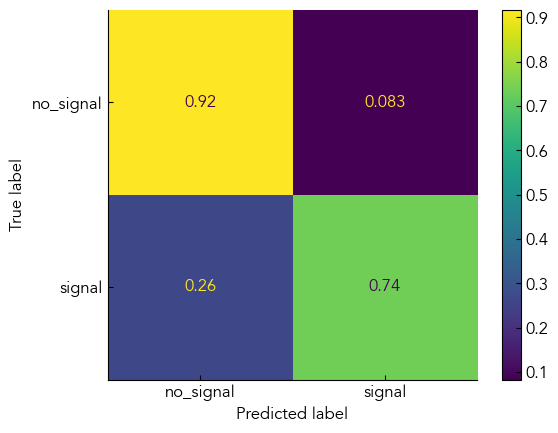

In [43]:
#threshold = -197
y_arc_true = []
y_arc_pred = []
for n, line in enumerate(lines):
    if n % 3 == 0:
        is_peptide = line.strip().split('|')[2] != 'NO_SP'
    if n % 3 == 1:
        sequence = line.strip().replace('X', 'A')[:NTERMINUS_LENGTH]
        if len(sequence) == NTERMINUS_LENGTH:
            log_prob, received = model.decode(np.array([symbols.index(s) for s in sequence]).reshape(-1, 1))
            #print(is_peptide, log_prob > -195)
            y_arc_true.append(1 * is_peptide)
            y_arc_pred.append(1 * log_prob > threshold)

labels = ['no_signal', 'signal']
cm = confusion_matrix(y_arc_true, y_arc_pred, labels=[0,1], normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()

### Save

In [1365]:
LOG_PROB_THRESHOLD = -134

import joblib
import json
save = False
if save is True:
    joblib.dump(model, MODEL_DESTINATION) 
    hmm_instructions = {
        'states' : list(states),
        'symbols' : list(symbols),
        'threshold_log_prob' : float(LOG_PROB_THRESHOLD),
        'signal_end_state' : SIGNAL_END_STATE,
        'nterminus_length' : NTERMINUS_LENGTH,
    }
    json.dump(hmm_instructions, open(f"{ROOT_DIR}/hmm/hmm_instructions.json", 'w'))